# <font color='CC3D3D'> ML Modeling
    
### GBM Model With Optuna

- CatBoost Model을 Base로 Optuna 패키지를 통해 하이퍼 파라미터 튜닝 실시
    - <span style="color:blue"> **Cat_Optuna_model_0.48_withLog.pkl** </span> 생성

- LGBM Model을 Base로 Optuna 패키지를 통해 하이퍼 파라미터 튜닝 실시
    - <span style="color:blue"> **LGBM_Optuna_model_0.44_WithLog.pkl** </span> 생성   
    
- <span style="color:green"> **master_train_data.csv**</span>와 <span style="color:green">**master_public_data.csv** </span>,
<span style="color:green">**master_private_data.csv** </span>,
<span style="color:green">**master_test_data.csv** </span>
불러와서 Training 및 validation 에 활용

In [ ]:
# GPU사용을 위한 LGBM 다시 깔기
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

fatal: destination path 'LightGBM' already exists and is not an empty directory.
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - found
-- Found OpenCL: /usr/lib/x86_64-linux-gnu/libOpenCL.so (found version "2.2") 
-- OpenCL include directory: /usr/include
-- Found Boost: /usr/include (found suitable version "1.65.1", minimum requir

# Import

In [ ]:
## Data Wrangling
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
# import pandas_profiling 
import seaborn as sns
%matplotlib inline
# import klib

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile

# Oversampling
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import optuna

## Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# from bayes_opt import BayesianOptimization
from optuna.samplers import TPESampler



## Modeling
### Classification Model

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

## Ensemble

from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingClassifier
from sklearn.base import RegressorMixin

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.base import ClassifierMixin

# from vecstack import StackingTransformer
# from vecstack import stacking


# CV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold


# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

# Utility
from tqdm import tqdm
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean
from scipy import stats
import joblib

# Auto ML
# import pycaret

In [ ]:
## rows 500

pd.set_option('display.max_rows', 500)

## columns

pd.set_option('display.max_columns', 500)

pd.set_option('display.width', 1000)

## Data Load

In [ ]:
train_df = pd.read_csv('../Data/master_train_data.csv')
public_df = pd.read_csv('../Data/master_public_data.csv')
private_df = pd.read_csv('../Data/master_private_data.csv')
test_df = pd.read_csv('../Data//master_test_data.csv')

In [ ]:
## catboost를 위한 데이터 타입 변환 
cat_feat = ['income_type', 'employment_type', 'houseown_type', 'purpose', 'personal_rehabilitation_yn',
       'personal_rehabilitation_complete_yn', 'gender', 'weekday', 'hour', 'foreign', 'bank_label', 'product_label']

for cat in cat_feat:
  train_df[cat] = train_df[cat].astype('int64')
  public_df[cat] = public_df[cat].astype('int64')
  private_df[cat] = private_df[cat].astype('int64')
  test_df[cat] = test_df[cat].astype('int64')

In [ ]:
train_df.shape

(7189007, 67)

In [ ]:
train_df.head(500)

,loan_limit,loan_rate,credit_score,yearly_income,income_type,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,enter_birth,gender,k_lending_rate,us_lending_rate,btc_price,btc_variance,eth_price,eth_variance,lunc_price,lunc_variance,Close,Open,High,Low,Volume,Change,실업자,실업률,현재가계부채CSI,가계부채전망CSI,소비심리지수,loanapply_insert_time_rank,loan_limit_avg_sub,loan_rate_avg_sub,bank_diversity,product_diversity,missing_value_cnt,working_year,working_month,age,holiday,weekday,hour,weekday_sin,weekday_cos,hour_sin,hour_cos,foreign,product_cnt,loan_limit_mean_x,loan_rate_mean_x,loan_limit_min_x,loan_rate_min_x,loan_limit_max_x,loan_rate_max_x,bank_label,loan_limit_min_y,loan_rate_min_y,loan_limit_max_y,loan_rate_max_y,loan_limit_mean_y,loan_rate_mean_y,product_label,is_applied
0,1000000.0,19.9,580.0,48000000.0,0,3,3,4.000000e+07,6,0,0,3.0,36000000.0,48.0,0,1.25,0.25,53396868.0,-0.0072,3590048.0,-0.0038,92.265297,0.0295,2703.52,2698.31,2716.46,2692.24,527950000,0.0016,52,1.8,102.0,100.0,94.67,2.0,-8.000000e+06,2.240000,4,5,2,2.0,10.0,50.0,0,3,2,0.433884,-0.900969,5.000000e-01,8.660254e-01,0,2,9.383907e+06,13.832713,0.0,5.1,5.000000e+07,19.9,2,0.0,5.1,5.000000e+07,19.9,9.964073e+06,14.619314,1,0.0
1,13000000.0,7.0,690.0,22000000.0,0,0,3,2.000000e+07,0,0,0,4.0,44200000.0,27.0,1,1.25,0.50,56626880.0,-0.0063,4068605.0,-0.0044,105.863876,-0.0292,2746.74,2758.31,2760.60,2740.02,824510,0.0021,76,2.3,102.0,102.0,92.00,27.0,-7.720930e+06,-4.662791,31,43,5,3.0,25.0,30.0,0,3,1,0.433884,-0.900969,2.588190e-01,9.659258e-01,0,2,1.807720e+07,9.653023,0.0,6.7,5.000000e+07,15.5,1,3000000.0,6.7,2.000000e+07,7.5,1.180752e+07,7.192589,0,0.0
2,3000000.0,12.5,630.0,36000000.0,0,3,3,2.000000e+07,6,0,0,4.0,135000000.0,34.0,1,1.50,1.00,40165832.0,-0.0204,2872367.0,-0.0722,1.097916,-0.9364,2592.27,2586.52,2599.11,2579.09,679510000,-0.0017,76,2.3,102.0,100.0,94.83,2.0,-5.333333e+06,-2.500000,6,6,1,1.0,5.0,35.0,0,3,12,0.433884,-0.900969,1.224647e-16,-1.000000e+00,0,3,1.094467e+07,11.122507,1000000.0,4.7,5.000000e+07,19.7,2,1000000.0,4.7,5.000000e+07,18.0,1.058262e+07,10.968330,1,0.0
3,2000000.0,16.8,650.0,24000000.0,0,3,3,2.000000e+06,6,0,0,35.0,58000000.0,31.0,0,1.25,0.50,56894732.0,0.0179,4025076.0,0.0237,97.122788,0.0313,2729.56,2721.22,2737.46,2707.74,768040000,-0.0002,65,3.1,103.0,102.0,93.83,1.0,0.000000e+00,0.000000,1,1,2,3.0,20.0,34.0,0,1,12,0.781831,0.623490,1.224647e-16,-1.000000e+00,0,1,1.588165e+07,16.255103,1000000.0,1.5,4.500000e+07,19.9,2,1000000.0,1.5,4.500000e+07,19.9,1.588165e+07,16.255103,1,1.0
4,36000000.0,10.8,940.0,45000000.0,0,3,0,4.000000e+07,7,0,0,3.0,38000000.0,37.0,1,1.50,1.00,39944508.0,0.0185,2729630.0,0.0142,0.000187,1.9330,2604.24,2570.01,2605.84,2565.96,788540000,0.0212,65,1.7,102.0,100.0,93.83,48.0,1.396226e+06,-1.264151,41,53,1,5.0,52.0,42.0,0,6,12,-0.781831,0.623490,1.224647e-16,-1.000000e+00,0,8,2.473095e+07,14.713284,3000000.0,6.8,1.000000e+08,19.9,2,3000000.0,6.8,1.000000e+08,19.7,3.614451e+07,13.070143,1,0.0
5,5000000.0,12.8,960.0,62000000.0,0,3,3,1.000000e+08,1,0,0,1.8,96000000.0,31.0,1,1.50,0.50,50521388.0,-0.0058,3822548.0,0.0035,80.947151,0.0072,2696.06,2695.52,2705.41,2685.01,693720000,-0.0076,73,2.2,100.0,97.0,96.17,12.0,-1.986047e+07,0.265116,34,43,4,5.0,54.0,36.0,0,6,8,-0.781831,0.623490,8.660254e-01,-5.000000e-01,0,3,1.100284e+07,13.351251,0.0,5.3,5.000000e+07,19.9,2,0.0,5.3,5.000000e+07,19.9,1.119295e+07,14.074397,1,0.0
6,6000000.0,12.3,810.0,50000000.0,0,3,2,7.000000e+07,7,0,0,6.0,134000000.0,33.0,1,1.50,0.50,48760856.0,-0.0379,3591822.0,-0.0459,88.450081,-0.0869,2668.31,2674.00,2678.05,2663.83,889940000,0.0042,62,1.6,101.0,98.0,93.83,21.0,-2.978378e+07,0.432432,35,37,1,10.0,114.0,43.0,0,2,18,0.974928,-0.222521,-1.000000e+00,-1.836970e-16,0,1,3.040976e+07,13.842291,1000000.0,9.5,1.000000e+08,19.9,0,1000000.0,9.5,1.000000e+08,19.9,3.040976e+07,13.842291,1,0.0
7,8000000.0,9.4,460.0,25000000.0,0,3,3,1.000000e+07,7,0,0,8.0,610000

### Target split

In [ ]:
tr_target = train_df.is_applied
train_df.drop('is_applied', axis = 1 , inplace = True)

pb_target = public_df.is_applied
public_df.drop('is_applied', axis = 1 , inplace = True)

# pr_target = private_df.is_applied
# private_df.drop('is_applied', axis = 1 , inplace = True)

te_target = test_df.is_applied
test_df.drop('is_applied', axis = 1 , inplace = True)

In [ ]:
train_df.head()

In [ ]:
train_df.shape

(7189007, 66)

# Train Valid Split

In [ ]:
# Hyper Params
seed = 12

# tr /te split target 비율은 알아서 맞춰줌
X_train, X_val, y_train, y_val = train_test_split(train_df, tr_target, test_size=0.2, random_state = seed, shuffle=True, stratify=tr_target)

# OverSampling & Undersampling

In [ ]:
### UnderSampling
# seed = 12

# X_train, X_valid, y_train, y_valid = train_test_split(train_df, tr_target, test_size=0.7, 
#                                                       random_state=42, shuffle=True, stratify=tr_target)


# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, 
                                                      # random_state=42, shuffle=True, stratify=y_train)

In [ ]:
# from imblearn.combine import SMOTETomek
# from imblearn.under_sampling import TomekLinks

# smoteto = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))

# X_train_smt, y_train_smt = smoteto.fit_resample(X_train, y_train)

#### Sampling한 Data Model 비교

In [ ]:
# # Linear
# lr = LogisticRegression(random_state = seed)

# #svc = SVC()

# # None Linear
# # mlp = MLPClassifier(random_state=seed)

# # knn
# # knn_clf = KNeighborsClassifier(n_jobs=-1)

# # tree model
# rf_clf = RandomForestClassifier(random_state=seed, n_jobs=-1)
# #extra_clf = ExtraTreesClassifier(random_state=seed, n_jobs=-1)

# # boosting
# gbm_clf = GradientBoostingClassifier(random_state=seed)
# xgb_clf = XGBClassifier(random_state=seed, n_jobs=-1)
# lgb_clf = LGBMClassifier(random_state=seed, n_jobs=-1)
# cat_clf = CatBoostClassifier(random_state=seed, verbose=False)

In [ ]:
# clfs = [lr,  rf_clf, lgb_clf, xgb_clf, gbm_clf]

# n_iter = 0
# kfold = StratifiedKFold(n_splits = 3)
# cv_f1_score = []


# for clf in clfs:
#   for train_index, dev_index in kfold.split(X_train_over, y_train_over):
#       X_train_cv, X_dev_cv = X_train_over.iloc[train_index, :], X_train_over.iloc[dev_index, :]
#       y_train_cv, y_dev_cv = y_train_over.iloc[train_index], y_train_over.iloc[dev_index]
      
#       clf.fit(X_train_cv, y_train_cv)
#       pred = clf.predict(X_dev_cv)
#       n_iter += 1
    

#       f1_score_scores = f1_score(y_dev_cv, pred)
    
#           # print('\n{0} 교차검증 정확도: {1}, 학습데이터 크기: {2}, 검증데이터 크기: {3}'.format(n_iter, nmae, train_size, test_size))
#           # print('\n{0} 검증 세트 인덱스: {1}'.format(n_iter, dev_index))
#       cv_f1_score.append(f1_score_scores)

#   pred_val = clf.predict(X_val)
#   f1_score_val = f1_score(y_val, pred_val)
    
#   print(f'{clf.__class__.__name__} Accuracy 평균 검증 정확도:', np.mean(cv_f1_score))
#   print(f'{clf.__class__.__name__} 과적합 확인용 val_data 정확도:', f1_score_val,'\n')

# Naive Model Score

### LGBM

In [ ]:
# start_time=time.time()

# lgbm = LGBMClassifier(scale_pos_weight = 9.5,
#                        learning_rate=0.1, 
#                        num_iterations = 1000, # n_estimator 랑 같은 것 같음
#                        max_depth = 4,
#                        n_jobs = -1,
#                        boost_from_average=False,
#                        objective = 'binary')

In [ ]:
# trained_model = lgbm.fit( X_train, y_train, 
#           eval_set=[(X_val, y_val)],
#           early_stopping_rounds=25, 
#           verbose = 5,
#           eval_metric ="logloss")                         

# train_pred = trained_model.predict(X_train)
# train_prob = trained_model.predict_proba(X_train)[:, 1]

# test_pred = trained_model.predict(X_val)
# test_prob = trained_model.predict_proba(X_val)[:, 1]

# accuracy = accuracy_score(y_val, test_pred)
# f1 = f1_score(y_val, test_pred)

# print('정확도: {0:.4f}, F1: {1:.4f}'.format(accuracy,f1))

### catboost

In [ ]:
# catboost = CatBoostClassifier(verbose=False,
#                               random_state = seed,
#                               cat_features = cat_feat,
#                               scale_pos_weight = 9.5)

# trained_model = catboost.fit(X_train, y_train,
#                              eval_set = (X_val, y_val))

# train_pred = trained_model.predict(X_train)
# train_prob = trained_model.predict_proba(X_train)[:, 1]

# test_pred = trained_model.predict(X_val)
# test_prob = trained_model.predict_proba(X_val)[:, 1]

# accuracy = accuracy_score(y_val, test_pred)
# f1 = f1_score(y_val, test_pred)

# print('정확도: {0:.4f}, F1: {1:.4f}'.format(accuracy,f1))

# public_pred =  trained_model.predict(public_df)

# accuracy = accuracy_score(pb_target, public_pred)
# f1 = f1_score(pb_target, public_pred)

# print('정확도: {0:.4f}, F1: {1:.4f}'.format(accuracy,f1))

### Focal Loss

In [ ]:
# from scipy import optimize
# from scipy import special

# class FocalLoss:
#     def __init__(self, gamma, alpha=None):
#         self.alpha = alpha
#         self.gamma = gamma

#     def at(self, y):
#         if self.alpha is None:
#             return np.ones_like(y)
#         return np.where(y, self.alpha, 1 - self.alpha)

#     def pt(self, y, p):
#         p = np.clip(p, 1e-15, 1 - 1e-15)
#         return np.where(y, p, 1 - p)

#     def __call__(self, y_true, y_pred):
#         at = self.at(y_true)
#         pt = self.pt(y_true, y_pred)
#         return -at * (1 - pt) ** self.gamma * np.log(pt)

#     def grad(self, y_true, y_pred):
#         y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
#         at = self.at(y_true)
#         pt = self.pt(y_true, y_pred)
#         g = self.gamma
#         return at * y * (1 - pt) ** g * (g * pt * np.log(pt) + pt - 1)

#     def hess(self, y_true, y_pred):
#         y = 2 * y_true - 1  # {0, 1} -> {-1, 1}
#         at = self.at(y_true)
#         pt = self.pt(y_true, y_pred)
#         g = self.gamma

#         u = at * y * (1 - pt) ** g
#         du = -at * y * g * (1 - pt) ** (g - 1)
#         v = g * pt * np.log(pt) + pt - 1
#         dv = g * np.log(pt) + g + 1

#         return (du * v + u * dv) * y * (pt * (1 - pt))

#     def init_score(self, y_true):
#         res = optimize.minimize_scalar(
#             lambda p: self(y_true, p).sum(),
#             bounds=(0, 1),
#             method='bounded'
#         )
#         p = res.x
#         log_odds = np.log(p / (1 - p))
#         return log_odds

#     def lgb_obj(self, preds, train_data):
#         y = train_data.get_label()
#         p = special.expit(preds)
#         return self.grad(y, p), self.hess(y, p)

#     def lgb_eval(self, preds, train_data):
#         y = train_data.get_label()
#         p = special.expit(preds)
#         is_higher_better = False
#         return 'focal_loss', self(y, p).mean(), is_higher_better

In [ ]:
# import lightgbm
# from scipy import optimize
# from scipy import special
# from sklearn import metrics
# from sklearn import model_selection
# import time

# start_time=time.time()
# fl = FocalLoss(alpha=None, gamma=2)

# fit = lightgbm.Dataset(
#     X_train, y_train,
#     init_score=np.full_like(y_train, fl.init_score(y_train), dtype=float)
# )

# val = lightgbm.Dataset(
#     X_val, y_val,
#     init_score=np.full_like(y_val, fl.init_score(y_train), dtype=float),
#     reference=fit # trainset 의미
# )

# model = lightgbm.train(
#     params={
#             'objective' : 'binary',
#             # 'scale_pos_weight': 11,
#             'learning_rate': 0.1, 
#             'num_iterations' : 1000,
#             'max_depth' : 4,
#             'n_jobs':-1,
#             'boost_from_average':False,
#             'metric' : 'logloss'},

#     train_set=fit,
#     valid_sets=(fit, val),
#     valid_names=('fit', 'val'),
#     early_stopping_rounds=25,
#     verbose_eval = 5,
#     fobj=fl.lgb_obj,
#     feval=fl.lgb_eval
# )


# train_prob = special.expit(fl.init_score(y_train) + model.predict(X_train))
# train_pred = (train_prob >= 0.5).astype('int')

# test_prob = special.expit(fl.init_score(y_train) + model.predict(X_val))
# test_pred = (test_prob >= 0.5).astype('int')


# # focal loss LGBM
# accuracy = accuracy_score(y_val, test_pred)
# f1 = f1_score(y_val, test_pred)

# print('정확도: {0:.4f}, F1: {1:.4f}'.format(accuracy,f1))

# Hyper Parmeter Tuning

#### LGBM

In [ ]:

sampler = TPESampler(seed=seed)

def objective_lgbm(trial):
    dtrain = lightgbm.Dataset(X_train, label = y_train)
    dtest = lightgbm.Dataset(X_val, label = y_val)

    params = {
        'objective': 'binary', # 이중분류
       #  'boosting_type': 'gbdt',
        'verbose': -1,
        'device_type': 'gpu',
        'metric': 'logloss',       # metric은 logloss
        'scale_pos_weight':trial.suggest_int('scale_pos_weight',1, 5),      # scale_pos_weight
        'max_depth': trial.suggest_int('max_depth',5, 30),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-4, 1e-1),
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'min_child_samples': trial.suggest_int('min_child_samples', 50, 200),
         'subsample': trial.suggest_loguniform('subsample', 0.3, 0.8),
        # "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 50, 1000, step=50),
        # "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        # "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
    }

    model = lightgbm.LGBMClassifier(**params)
    lgb_model = model.fit(X_train, y_train, 
                          eval_set=[(X_val, y_val)],
                          eval_metric ="logloss" ,
                          # eval_class_weight = {'0': 0.95,
                          #                      '1': 0.05},
                          # verbose=10, 
                          callbacks = [lightgbm.early_stopping(stopping_rounds = 20, first_metric_only=False)])
    
    # early_stopping_rounds = 25
    f1 = f1_score(y_val, lgb_model.predict(X_val))
    return f1
        
study_lgb = optuna.create_study(direction = 'maximize', sampler = sampler)
study_lgb.optimize(objective_lgbm, n_trials = 50)

[I 2022-10-13 14:32:45,015] A new study created in memory with name: no-name-f069be66-c3b0-4bc2-8a19-398b78e2dd73


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1301]	valid_0's binary_logloss: 0.162443


[I 2022-10-13 14:38:31,112] Trial 0 finished with value: 0.0 and parameters: {'scale_pos_weight': 1, 'max_depth': 24, 'learning_rate': 0.0006165169845402056, 'n_estimators': 1301, 'min_child_samples': 52, 'subsample': 0.7387181218502914}. Best is trial 0 with value: 0.0.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.175757


[I 2022-10-13 14:38:53,870] Trial 1 finished with value: 0.0 and parameters: {'scale_pos_weight': 5, 'max_depth': 5, 'learning_rate': 0.07427591470449847, 'n_estimators': 705, 'min_child_samples': 92, 'subsample': 0.5436178898207538}. Best is trial 0 with value: 0.0.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1282]	valid_0's binary_logloss: 0.186661


[I 2022-10-13 14:44:35,969] Trial 2 finished with value: 0.0 and parameters: {'scale_pos_weight': 5, 'max_depth': 27, 'learning_rate': 0.00010157286454806994, 'n_estimators': 1282, 'min_child_samples': 133, 'subsample': 0.4829218506802711}. Best is trial 0 with value: 0.0.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.170392


[I 2022-10-13 14:45:06,121] Trial 3 finished with value: 0.0 and parameters: {'scale_pos_weight': 4, 'max_depth': 9, 'learning_rate': 0.019664429488309237, 'n_estimators': 531, 'min_child_samples': 70, 'subsample': 0.3362404239191708}. Best is trial 0 with value: 0.0.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1725]	valid_0's binary_logloss: 0.148827


[I 2022-10-13 14:53:16,436] Trial 4 finished with value: 0.3878582190634179 and parameters: {'scale_pos_weight': 2, 'max_depth': 22, 'learning_rate': 0.002592324323127745, 'n_estimators': 1725, 'min_child_samples': 93, 'subsample': 0.6157579079069015}. Best is trial 4 with value: 0.3878582190634179.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[654]	valid_0's binary_logloss: 0.170341


[I 2022-10-13 14:56:22,672] Trial 5 finished with value: 0.0 and parameters: {'scale_pos_weight': 4, 'max_depth': 13, 'learning_rate': 0.0010091194741007165, 'n_estimators': 1968, 'min_child_samples': 144, 'subsample': 0.7619475941301447}. Best is trial 4 with value: 0.3878582190634179.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[401]	valid_0's binary_logloss: 0.170339


[I 2022-10-13 14:58:25,276] Trial 6 finished with value: 0.0 and parameters: {'scale_pos_weight': 4, 'max_depth': 26, 'learning_rate': 0.001659284687670616, 'n_estimators': 1177, 'min_child_samples': 110, 'subsample': 0.7961941738583236}. Best is trial 4 with value: 0.3878582190634179.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1136]	valid_0's binary_logloss: 0.146285


[I 2022-10-13 15:03:34,913] Trial 7 finished with value: 0.0141691713181623 and parameters: {'scale_pos_weight': 1, 'max_depth': 30, 'learning_rate': 0.0018103010811173163, 'n_estimators': 1136, 'min_child_samples': 119, 'subsample': 0.4328282818150388}. Best is trial 4 with value: 0.3878582190634179.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1599]	valid_0's binary_logloss: 0.176464


[I 2022-10-13 15:10:35,469] Trial 8 finished with value: 0.0 and parameters: {'scale_pos_weight': 3, 'max_depth': 5, 'learning_rate': 0.00017898556590768784, 'n_estimators': 1599, 'min_child_samples': 146, 'subsample': 0.30832525557267637}. Best is trial 4 with value: 0.3878582190634179.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1285]	valid_0's binary_logloss: 0.184575


[I 2022-10-13 15:16:05,804] Trial 9 finished with value: 0.0 and parameters: {'scale_pos_weight': 2, 'max_depth': 10, 'learning_rate': 0.00014623791283777576, 'n_estimators': 1285, 'min_child_samples': 112, 'subsample': 0.3145291740234179}. Best is trial 4 with value: 0.3878582190634179.


In [ ]:
trial = study_lgb.best_trial
trial_params = trial.params
# trial_params['scale_pos_weight'] =  9.5
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

Best Trial: score 0.3878582190634179,
params {'scale_pos_weight': 2, 'max_depth': 22, 'learning_rate': 0.002592324323127745, 'n_estimators': 1725, 'min_child_samples': 93, 'subsample': 0.6157579079069015}


In [ ]:
final_lgb_model = lightgbm.LGBMClassifier(**trial_params)
final_lgb_model.fit(X_train, y_train)
final_lgb_pred = final_lgb_model.predict(X_val)
final_lgb_test = final_lgb_model.predict(public_df)

F1_pred = f1_score(y_val, final_lgb_pred)
F1_test = f1_score(pb_target, final_lgb_test)

print('F1 validation: ', F1_pred)
print('F1 public: ', F1_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=71 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 313788, number of negative: 5437417
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.511910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5290
[LightGBM] [Info] Number of data points in the train set: 5751205, number of

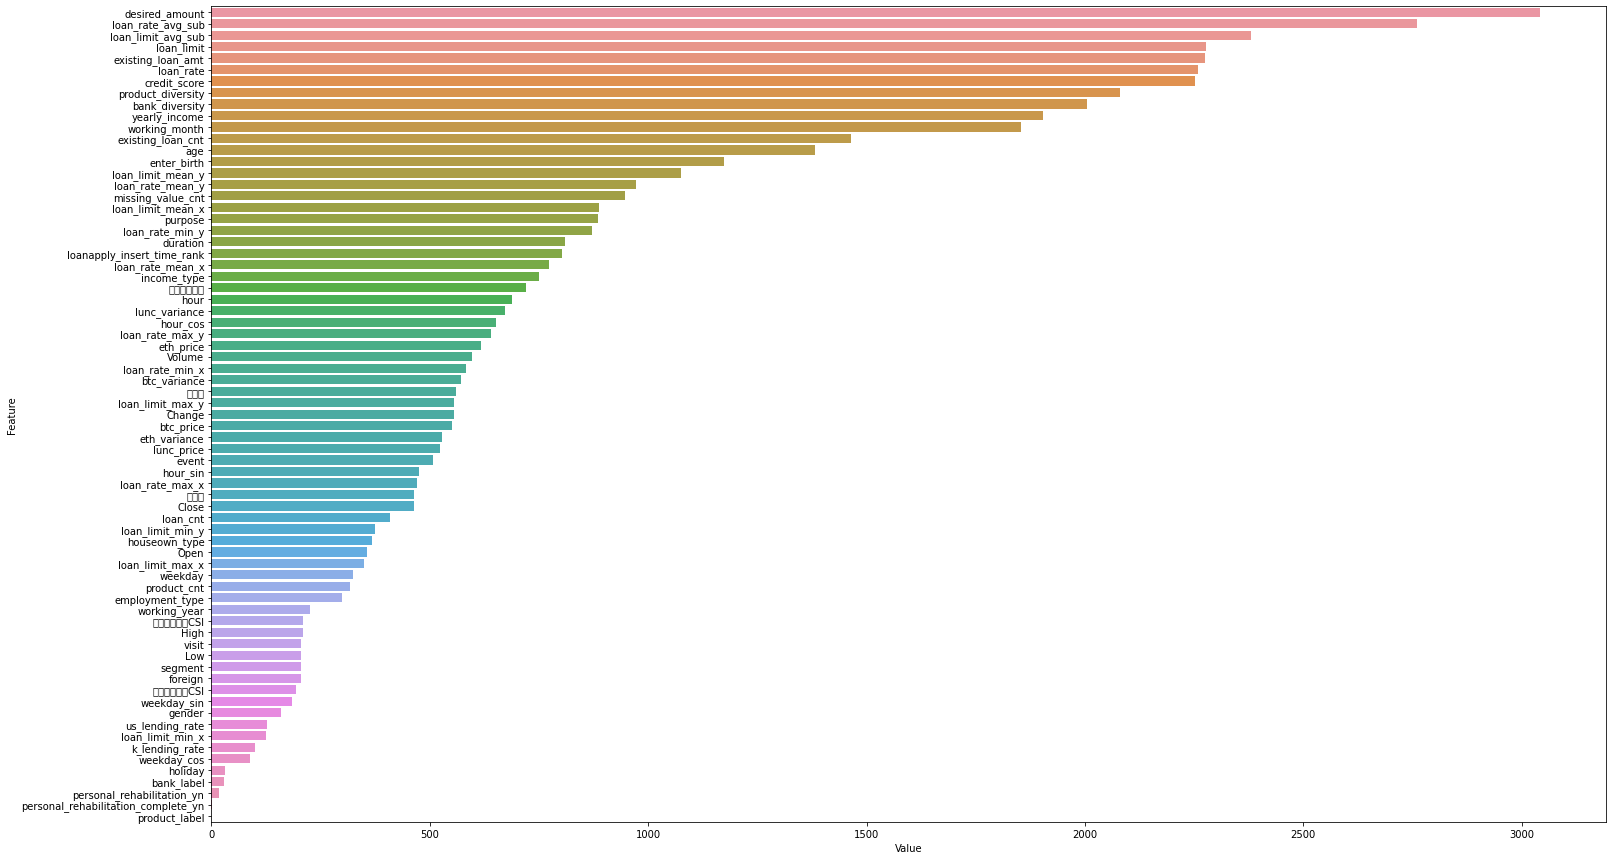

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(final_lgb_model.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(25, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.show()

#### LGBM 모델 저장

In [ ]:
joblib.dump(final_lgb_model, '../Data/LGBM_Optuna_model_0.44_WithLog.pkl')

['/content/drive/MyDrive/빅콘 2022/LGBM_Optuna_model_0.44_WithLog_ver2.pkl']

## CatBoost

In [ ]:
sampler = TPESampler(seed=seed)

def objective(trial):
  param = {
      'iterations':trial.suggest_int("iterations", 500, 3000),
      "random_state": seed,
        'objective':trial.suggest_categorical('objective',['Logloss']),
        'od_wait':trial.suggest_int('od_wait', 500, 1000),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.01,1),
        'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
        'random_strength': trial.suggest_uniform('random_strength',20,50),
        'scale_pos_weight':trial.suggest_int('scale_pos_weight',1, 9),
        'depth': trial.suggest_int('depth',1,15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,20),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'verbose': False,
        "eval_metric":'F1',
        "one_hot_max_size":trial.suggest_int("one_hot_max_size",1,5),
        'task_type' : 'GPU'      
      # 'scale_pos_weight':trial.suggest_int('scale_pos_weight',1, 9),
      # 'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
      # 'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
      # "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
      # "max_depth":trial.suggest_int("max_depth", 4, 16),
      # 'random_strength' :trial.suggest_int('random_strength', 0, 100),
      # "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
      # "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
      # "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
      # "max_bin": trial.suggest_int("max_bin", 200, 500),
      # 'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
  }
  
  cat_features = cat_feat

  cat = CatBoostClassifier(**param)
  cat.fit(X_train, y_train,
          eval_set=[ (X_val,y_val)],
          early_stopping_rounds=15, 
          cat_features=cat_features,
          verbose=100)
  
  f1 = f1_score(y_val, cat.predict(X_val))
  return f1


study = optuna.create_study(
    study_name = 'cat_parameter_opt',
    direction = 'maximize',
    sampler = sampler,
)
study.optimize(objective, n_trials = 30)

[I 2022-10-11 04:38:32,209] A new study created in memory with name: cat_parameter_opt


0:	learn: 0.7226820	test: 0.7207371	best: 0.7207371 (0)	total: 4.53s	remaining: 1h 6m 47s
100:	learn: 0.8152619	test: 0.7739835	best: 0.7744752 (95)	total: 6m 39s	remaining: 51m 37s
bestTest = 0.7744751799
bestIteration = 95
Shrink model to first 96 iterations.


[I 2022-10-11 04:46:41,363] Trial 0 finished with value: 0.4178439541545283 and parameters: {'iterations': 885, 'objective': 'Logloss', 'od_wait': 870, 'learning_rate': 0.27068186503328334, 'reg_lambda': 53.373944000635845, 'random_strength': 20.43724887456259, 'scale_pos_weight': 9, 'depth': 14, 'min_data_in_leaf': 1, 'leaf_estimation_iterations': 15, 'one_hot_max_size': 1}. Best is trial 0 with value: 0.4178439541545283.


0:	learn: 0.5527167	test: 0.5503101	best: 0.5503101 (0)	total: 1.77s	remaining: 35m 44s
bestTest = 0.6836601447
bestIteration = 56
Shrink model to first 57 iterations.


[I 2022-10-11 04:49:25,466] Trial 1 finished with value: 0.4445592435989824 and parameters: {'iterations': 1209, 'objective': 'Logloss', 'od_wait': 803, 'learning_rate': 0.9447828846925117, 'reg_lambda': 85.27355558357308, 'random_strength': 20.067777005555406, 'scale_pos_weight': 5, 'depth': 9, 'min_data_in_leaf': 10, 'leaf_estimation_iterations': 12, 'one_hot_max_size': 1}. Best is trial 1 with value: 0.4445592435989824.


0:	learn: 0.6077607	test: 0.6059867	best: 0.6059867 (0)	total: 858ms	remaining: 34m 27s
100:	learn: 0.7259330	test: 0.7222016	best: 0.7222105 (98)	total: 1m 16s	remaining: 29m 16s
200:	learn: 0.7434801	test: 0.7395176	best: 0.7395176 (200)	total: 2m 30s	remaining: 27m 36s
300:	learn: 0.7494591	test: 0.7433603	best: 0.7433644 (299)	total: 3m 44s	remaining: 26m 11s
400:	learn: 0.7533737	test: 0.7452842	best: 0.7452842 (400)	total: 4m 58s	remaining: 24m 56s
bestTest = 0.7459927648
bestIteration = 424
Shrink model to first 425 iterations.


[I 2022-10-11 04:55:21,660] Trial 2 finished with value: 0.4351261221453039 and parameters: {'iterations': 2412, 'objective': 'Logloss', 'od_wait': 510, 'learning_rate': 0.1438580765854257, 'reg_lambda': 11.627310577438807, 'random_strength': 29.296927534700878, 'scale_pos_weight': 7, 'depth': 8, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 5, 'one_hot_max_size': 4}. Best is trial 1 with value: 0.4445592435989824.


0:	learn: 0.6996309	test: 0.6983958	best: 0.6983958 (0)	total: 2.04s	remaining: 1h 16m 49s
100:	learn: 0.7964306	test: 0.7784789	best: 0.7784789 (100)	total: 2m 54s	remaining: 1h 2m 12s
bestTest = 0.7796546942
bestIteration = 147
Shrink model to first 148 iterations.


[I 2022-10-11 05:00:43,085] Trial 3 finished with value: 0.41908553637603496 and parameters: {'iterations': 2257, 'objective': 'Logloss', 'od_wait': 664, 'learning_rate': 0.3413010538149952, 'reg_lambda': 97.8058081210711, 'random_strength': 38.73746335206057, 'scale_pos_weight': 9, 'depth': 12, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 7, 'one_hot_max_size': 3}. Best is trial 1 with value: 0.4445592435989824.


0:	learn: 0.4663069	test: 0.4626280	best: 0.4626280 (0)	total: 1.13s	remaining: 28m 16s
100:	learn: 0.6234195	test: 0.6203120	best: 0.6203120 (100)	total: 1m 57s	remaining: 27m 5s
200:	learn: 0.6446827	test: 0.6411979	best: 0.6411979 (200)	total: 3m 57s	remaining: 25m 32s
300:	learn: 0.6524780	test: 0.6462167	best: 0.6462167 (300)	total: 5m 55s	remaining: 23m 38s
400:	learn: 0.6564155	test: 0.6486569	best: 0.6487844 (394)	total: 7m 56s	remaining: 21m 46s
bestTest = 0.6501622297
bestIteration = 461
Shrink model to first 462 iterations.


[I 2022-10-11 05:10:49,818] Trial 4 finished with value: 0.4646536447149536 and parameters: {'iterations': 1501, 'objective': 'Logloss', 'od_wait': 998, 'learning_rate': 0.18578853417851043, 'reg_lambda': 96.25969067681599, 'random_strength': 32.577508107773184, 'scale_pos_weight': 4, 'depth': 7, 'min_data_in_leaf': 8, 'leaf_estimation_iterations': 7, 'one_hot_max_size': 1}. Best is trial 4 with value: 0.4646536447149536.


0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 95.9ms	remaining: 1m 8s
100:	learn: 0.4160651	test: 0.4144319	best: 0.4168223 (98)	total: 7.76s	remaining: 46.8s
200:	learn: 0.4270487	test: 0.4257587	best: 0.4257587 (200)	total: 15.4s	remaining: 39s
bestTest = 0.4273627228
bestIteration = 211
Shrink model to first 212 iterations.


[I 2022-10-11 05:11:43,259] Trial 5 finished with value: 0.37686345537606414 and parameters: {'iterations': 710, 'objective': 'Logloss', 'od_wait': 866, 'learning_rate': 0.6398379938945389, 'reg_lambda': 2.790788607075367, 'random_strength': 29.0051017947196, 'scale_pos_weight': 2, 'depth': 1, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 7, 'one_hot_max_size': 1}. Best is trial 4 with value: 0.4646536447149536.


0:	learn: 0.5467989	test: 0.5448194	best: 0.5448194 (0)	total: 852ms	remaining: 27m 25s
100:	learn: 0.6569406	test: 0.6539435	best: 0.6539435 (100)	total: 1m 20s	remaining: 24m 15s
200:	learn: 0.6827292	test: 0.6792493	best: 0.6792548 (199)	total: 2m 39s	remaining: 22m 50s
300:	learn: 0.6922057	test: 0.6862939	best: 0.6862939 (300)	total: 3m 58s	remaining: 21m 30s
bestTest = 0.6896977771
bestIteration = 377
Shrink model to first 378 iterations.


[I 2022-10-11 05:17:22,939] Trial 6 finished with value: 0.4556795797767564 and parameters: {'iterations': 1931, 'objective': 'Logloss', 'od_wait': 902, 'learning_rate': 0.12246570234441884, 'reg_lambda': 27.711728671347476, 'random_strength': 39.25034275056269, 'scale_pos_weight': 5, 'depth': 8, 'min_data_in_leaf': 10, 'leaf_estimation_iterations': 14, 'one_hot_max_size': 4}. Best is trial 4 with value: 0.4646536447149536.


0:	learn: 0.6363922	test: 0.6364320	best: 0.6364320 (0)	total: 145ms	remaining: 4m 50s
100:	learn: 0.7582364	test: 0.7572594	best: 0.7573099 (99)	total: 11.6s	remaining: 3m 39s
200:	learn: 0.7659433	test: 0.7647695	best: 0.7649437 (193)	total: 22.9s	remaining: 3m 25s
300:	learn: 0.7695767	test: 0.7684064	best: 0.7684400 (299)	total: 34.2s	remaining: 3m 13s
400:	learn: 0.7717394	test: 0.7704116	best: 0.7704116 (400)	total: 45.4s	remaining: 3m 1s
bestTest = 0.7714003807
bestIteration = 453
Shrink model to first 454 iterations.


[I 2022-10-11 05:18:43,305] Trial 7 finished with value: 0.40738710572439785 and parameters: {'iterations': 2008, 'objective': 'Logloss', 'od_wait': 722, 'learning_rate': 0.4852463154936213, 'reg_lambda': 88.84475383849401, 'random_strength': 26.255014653805404, 'scale_pos_weight': 9, 'depth': 2, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 1, 'one_hot_max_size': 4}. Best is trial 4 with value: 0.4646536447149536.


0:	learn: 0.6952599	test: 0.6943375	best: 0.6943375 (0)	total: 1.7s	remaining: 59m 9s
bestTest = 0.7726070603
bestIteration = 59
Shrink model to first 60 iterations.


[I 2022-10-11 05:21:02,716] Trial 8 finished with value: 0.40491490477956776 and parameters: {'iterations': 2094, 'objective': 'Logloss', 'od_wait': 932, 'learning_rate': 0.9422213352162603, 'reg_lambda': 44.56271088479204, 'random_strength': 40.09872897307265, 'scale_pos_weight': 9, 'depth': 10, 'min_data_in_leaf': 7, 'leaf_estimation_iterations': 5, 'one_hot_max_size': 2}. Best is trial 4 with value: 0.4646536447149536.


0:	learn: 0.0080842	test: 0.0074619	best: 0.0074619 (0)	total: 1.81s	remaining: 1h 27m 33s
100:	learn: 0.3506284	test: 0.3031822	best: 0.3033431 (92)	total: 2m 45s	remaining: 1h 16m 9s
200:	learn: 0.4098530	test: 0.3151347	best: 0.3155147 (192)	total: 5m 31s	remaining: 1h 13m 57s
bestTest = 0.3199486433
bestIteration = 243
Shrink model to first 244 iterations.


[I 2022-10-11 05:28:41,448] Trial 9 finished with value: 0.3198820677929313 and parameters: {'iterations': 2894, 'objective': 'Logloss', 'od_wait': 703, 'learning_rate': 0.9470902641391751, 'reg_lambda': 85.71905731128878, 'random_strength': 40.66782998097373, 'scale_pos_weight': 1, 'depth': 14, 'min_data_in_leaf': 19, 'leaf_estimation_iterations': 1, 'one_hot_max_size': 4}. Best is trial 4 with value: 0.4646536447149536.


0:	learn: 0.4139320	test: 0.4110591	best: 0.4110591 (0)	total: 487ms	remaining: 11m 30s
bestTest = 0.4140193068
bestIteration = 1
Shrink model to first 2 iterations.


[I 2022-10-11 05:29:19,466] Trial 10 finished with value: 0.3295665373587452 and parameters: {'iterations': 1418, 'objective': 'Logloss', 'od_wait': 983, 'learning_rate': 0.01528822307345587, 'reg_lambda': 62.66432683715917, 'random_strength': 33.65451171107125, 'scale_pos_weight': 3, 'depth': 4, 'min_data_in_leaf': 3, 'leaf_estimation_iterations': 10, 'one_hot_max_size': 2}. Best is trial 4 with value: 0.4646536447149536.


0:	learn: 0.5140619	test: 0.5118552	best: 0.5118552 (0)	total: 596ms	remaining: 15m 35s
bestTest = 0.5522886412
bestIteration = 14
Shrink model to first 15 iterations.


[I 2022-10-11 05:30:03,613] Trial 11 finished with value: 0.37200180086006596 and parameters: {'iterations': 1571, 'objective': 'Logloss', 'od_wait': 989, 'learning_rate': 0.035805089900227724, 'reg_lambda': 24.100694587120643, 'random_strength': 48.43816942239057, 'scale_pos_weight': 5, 'depth': 6, 'min_data_in_leaf': 7, 'leaf_estimation_iterations': 14, 'one_hot_max_size': 5}. Best is trial 4 with value: 0.4646536447149536.


0:	learn: 0.4796033	test: 0.4763135	best: 0.4763135 (0)	total: 679ms	remaining: 20m 4s
100:	learn: 0.6302918	test: 0.6271004	best: 0.6271004 (100)	total: 1m 7s	remaining: 18m 45s
200:	learn: 0.6461543	test: 0.6417536	best: 0.6417536 (200)	total: 2m 13s	remaining: 17m 21s
300:	learn: 0.6517427	test: 0.6464782	best: 0.6464782 (300)	total: 3m 17s	remaining: 16m 6s
400:	learn: 0.6561769	test: 0.6491535	best: 0.6491535 (400)	total: 4m 22s	remaining: 14m 58s
bestTest = 0.6495652174
bestIteration = 416
Shrink model to first 417 iterations.


[I 2022-10-11 05:35:16,893] Trial 12 finished with value: 0.46348165218932813 and parameters: {'iterations': 1774, 'objective': 'Logloss', 'od_wait': 895, 'learning_rate': 0.25306740621735185, 'reg_lambda': 31.313950174318837, 'random_strength': 45.831324848428885, 'scale_pos_weight': 4, 'depth': 6, 'min_data_in_leaf': 7, 'leaf_estimation_iterations': 10, 'one_hot_max_size': 3}. Best is trial 4 with value: 0.4646536447149536.


0:	learn: 0.4161785	test: 0.4133953	best: 0.4133953 (0)	total: 633ms	remaining: 12m 23s
100:	learn: 0.5674790	test: 0.5639058	best: 0.5639058 (100)	total: 58.7s	remaining: 10m 25s
200:	learn: 0.5830531	test: 0.5791193	best: 0.5791193 (200)	total: 1m 55s	remaining: 9m 18s
300:	learn: 0.5893740	test: 0.5838685	best: 0.5840048 (297)	total: 2m 51s	remaining: 8m 19s
400:	learn: 0.5935645	test: 0.5868040	best: 0.5868040 (400)	total: 3m 47s	remaining: 7m 19s
bestTest = 0.5888595703
bestIteration = 481
Shrink model to first 482 iterations.


[I 2022-10-11 05:40:29,681] Trial 13 finished with value: 0.4622861630567158 and parameters: {'iterations': 1176, 'objective': 'Logloss', 'od_wait': 804, 'learning_rate': 0.33221083680504004, 'reg_lambda': 68.7245391392864, 'random_strength': 48.71430037443925, 'scale_pos_weight': 3, 'depth': 5, 'min_data_in_leaf': 6, 'leaf_estimation_iterations': 10, 'one_hot_max_size': 2}. Best is trial 4 with value: 0.4646536447149536.


0:	learn: 0.4796033	test: 0.4763135	best: 0.4763135 (0)	total: 684ms	remaining: 19m 14s
100:	learn: 0.6453325	test: 0.6398350	best: 0.6400850 (99)	total: 1m 7s	remaining: 17m 42s
200:	learn: 0.6548272	test: 0.6463090	best: 0.6463090 (200)	total: 2m 12s	remaining: 16m 21s
300:	learn: 0.6596983	test: 0.6492056	best: 0.6494343 (296)	total: 3m 17s	remaining: 15m 11s
bestTest = 0.6494343494
bestIteration = 296
Shrink model to first 297 iterations.


[I 2022-10-11 05:44:24,596] Trial 14 finished with value: 0.4621030248988271 and parameters: {'iterations': 1689, 'objective': 'Logloss', 'od_wait': 941, 'learning_rate': 0.5140811678299207, 'reg_lambda': 41.348647036880486, 'random_strength': 44.275917961729526, 'scale_pos_weight': 4, 'depth': 6, 'min_data_in_leaf': 14, 'leaf_estimation_iterations': 9, 'one_hot_max_size': 3}. Best is trial 4 with value: 0.4646536447149536.


0:	learn: 0.6089107	test: 0.6089758	best: 0.6089758 (0)	total: 252ms	remaining: 10m 33s
100:	learn: 0.7178018	test: 0.7174824	best: 0.7174824 (100)	total: 22s	remaining: 8m 45s
200:	learn: 0.7283095	test: 0.7273308	best: 0.7273308 (200)	total: 43s	remaining: 8m 14s
300:	learn: 0.7332272	test: 0.7313236	best: 0.7313236 (300)	total: 1m 4s	remaining: 7m 51s
400:	learn: 0.7356208	test: 0.7342084	best: 0.7342084 (400)	total: 1m 25s	remaining: 7m 27s
500:	learn: 0.7379217	test: 0.7360070	best: 0.7360545 (499)	total: 1m 46s	remaining: 7m 6s
600:	learn: 0.7398017	test: 0.7373953	best: 0.7373953 (600)	total: 2m 7s	remaining: 6m 44s
bestTest = 0.7381540001
bestIteration = 636
Shrink model to first 637 iterations.


[I 2022-10-11 05:47:10,484] Trial 15 finished with value: 0.4301889374123442 and parameters: {'iterations': 2510, 'objective': 'Logloss', 'od_wait': 798, 'learning_rate': 0.2334206731452415, 'reg_lambda': 30.186868734908728, 'random_strength': 33.15998070458651, 'scale_pos_weight': 7, 'depth': 3, 'min_data_in_leaf': 5, 'leaf_estimation_iterations': 4, 'one_hot_max_size': 5}. Best is trial 4 with value: 0.4646536447149536.


0:	learn: 0.5703066	test: 0.5678787	best: 0.5678787 (0)	total: 1.01s	remaining: 21m 21s
100:	learn: 0.7211944	test: 0.7162742	best: 0.7162742 (100)	total: 1m 31s	remaining: 17m 45s
200:	learn: 0.7290651	test: 0.7205260	best: 0.7207962 (198)	total: 3m 2s	remaining: 16m 11s
bestTest = 0.7221317785
bestIteration = 246
Shrink model to first 247 iterations.


[I 2022-10-11 05:51:39,809] Trial 16 finished with value: 0.44437814956661964 and parameters: {'iterations': 1274, 'objective': 'Logloss', 'od_wait': 997, 'learning_rate': 0.4635171941479709, 'reg_lambda': 68.71489550039487, 'random_strength': 35.832309241276555, 'scale_pos_weight': 6, 'depth': 7, 'min_data_in_leaf': 8, 'leaf_estimation_iterations': 12, 'one_hot_max_size': 2}. Best is trial 4 with value: 0.4646536447149536.


0:	learn: 0.4449282	test: 0.4406343	best: 0.4406343 (0)	total: 1.52s	remaining: 44m 41s
bestTest = 0.5840176681
bestIteration = 63
Shrink model to first 64 iterations.


[I 2022-10-11 05:54:10,135] Trial 17 finished with value: 0.455855286186922 and parameters: {'iterations': 1765, 'objective': 'Logloss', 'od_wait': 621, 'learning_rate': 0.6830069095919813, 'reg_lambda': 14.971455398443766, 'random_strength': 44.85646854744749, 'scale_pos_weight': 3, 'depth': 11, 'min_data_in_leaf': 4, 'leaf_estimation_iterations': 8, 'one_hot_max_size': 3}. Best is trial 4 with value: 0.4646536447149536.


0:	learn: 0.0069739	test: 0.0067839	best: 0.0067839 (0)	total: 458ms	remaining: 6m 46s
100:	learn: 0.1892358	test: 0.1868991	best: 0.1868991 (100)	total: 43.2s	remaining: 5m 36s
200:	learn: 0.2448614	test: 0.2428675	best: 0.2428675 (200)	total: 1m 23s	remaining: 4m 43s
300:	learn: 0.2585342	test: 0.2545513	best: 0.2548345 (293)	total: 2m 2s	remaining: 3m 59s
400:	learn: 0.2664394	test: 0.2612560	best: 0.2614144 (398)	total: 2m 42s	remaining: 3m 17s
bestTest = 0.2633006633
bestIteration = 430
Shrink model to first 431 iterations.


[I 2022-10-11 05:57:42,061] Trial 18 finished with value: 0.26330066330066326 and parameters: {'iterations': 887, 'objective': 'Logloss', 'od_wait': 855, 'learning_rate': 0.15773647195217355, 'reg_lambda': 37.927615891782956, 'random_strength': 43.39721595867303, 'scale_pos_weight': 1, 'depth': 4, 'min_data_in_leaf': 14, 'leaf_estimation_iterations': 12, 'one_hot_max_size': 3}. Best is trial 4 with value: 0.4646536447149536.


0:	learn: 0.5098145	test: 0.5063778	best: 0.5063778 (0)	total: 2.74s	remaining: 2h 4m 7s
100:	learn: 0.6706642	test: 0.6469833	best: 0.6475185 (98)	total: 4m 5s	remaining: 1h 46m
bestTest = 0.6480969152
bestIteration = 115
Shrink model to first 116 iterations.


[I 2022-10-11 06:03:49,458] Trial 19 finished with value: 0.4638986573286445 and parameters: {'iterations': 2721, 'objective': 'Logloss', 'od_wait': 937, 'learning_rate': 0.40450980966500105, 'reg_lambda': 55.32639601639427, 'random_strength': 24.891523014023605, 'scale_pos_weight': 4, 'depth': 12, 'min_data_in_leaf': 1, 'leaf_estimation_iterations': 3, 'one_hot_max_size': 1}. Best is trial 4 with value: 0.4646536447149536.


0:	learn: 0.5098145	test: 0.5063778	best: 0.5063778 (0)	total: 2.74s	remaining: 2h 16m 41s
bestTest = 0.6429267334
bestIteration = 55
Shrink model to first 56 iterations.


[I 2022-10-11 06:07:25,476] Trial 20 finished with value: 0.45521673731710655 and parameters: {'iterations': 2992, 'objective': 'Logloss', 'od_wait': 571, 'learning_rate': 0.7572081676610324, 'reg_lambda': 56.30880221509082, 'random_strength': 24.745778137333836, 'scale_pos_weight': 4, 'depth': 12, 'min_data_in_leaf': 2, 'leaf_estimation_iterations': 3, 'one_hot_max_size': 1}. Best is trial 4 with value: 0.4646536447149536.


0:	learn: 0.5307398	test: 0.5270745	best: 0.5270745 (0)	total: 3.4s	remaining: 2h 33m 17s
bestTest = 0.6432668379
bestIteration = 83
Shrink model to first 84 iterations.


[I 2022-10-11 06:14:28,459] Trial 21 finished with value: 0.4616385826850489 and parameters: {'iterations': 2709, 'objective': 'Logloss', 'od_wait': 936, 'learning_rate': 0.42363195926959446, 'reg_lambda': 73.32176757569962, 'random_strength': 30.547413952595065, 'scale_pos_weight': 4, 'depth': 15, 'min_data_in_leaf': 9, 'leaf_estimation_iterations': 3, 'one_hot_max_size': 1}. Best is trial 4 with value: 0.4646536447149536.


0:	learn: 0.5954571	test: 0.5918213	best: 0.5918213 (0)	total: 1.34s	remaining: 34m 35s
100:	learn: 0.7243463	test: 0.7170702	best: 0.7170702 (100)	total: 2m	remaining: 28m 43s
200:	learn: 0.7361737	test: 0.7224101	best: 0.7225193 (198)	total: 4m 4s	remaining: 27m 22s
bestTest = 0.7232211948
bestIteration = 211
Shrink model to first 212 iterations.


[I 2022-10-11 06:19:39,766] Trial 22 finished with value: 0.4465029656470778 and parameters: {'iterations': 1549, 'objective': 'Logloss', 'od_wait': 903, 'learning_rate': 0.3728443693549419, 'reg_lambda': 99.64617015956577, 'random_strength': 25.096359699434498, 'scale_pos_weight': 6, 'depth': 9, 'min_data_in_leaf': 4, 'leaf_estimation_iterations': 6, 'one_hot_max_size': 2}. Best is trial 4 with value: 0.4646536447149536.


0:	learn: 0.1206302	test: 0.1164379	best: 0.1164379 (0)	total: 995ms	remaining: 44m 14s
100:	learn: 0.4609116	test: 0.4572369	best: 0.4574541 (99)	total: 1m 37s	remaining: 41m 9s
200:	learn: 0.4840112	test: 0.4786403	best: 0.4788146 (199)	total: 3m 13s	remaining: 39m 38s
300:	learn: 0.4925146	test: 0.4856185	best: 0.4856282 (299)	total: 4m 51s	remaining: 38m 11s
bestTest = 0.4877843034
bestIteration = 346
Shrink model to first 347 iterations.


[I 2022-10-11 06:26:08,385] Trial 23 finished with value: 0.43097411089704823 and parameters: {'iterations': 2670, 'objective': 'Logloss', 'od_wait': 965, 'learning_rate': 0.2409122873226729, 'reg_lambda': 77.77577131826945, 'random_strength': 36.17448045149216, 'scale_pos_weight': 2, 'depth': 6, 'min_data_in_leaf': 1, 'leaf_estimation_iterations': 10, 'one_hot_max_size': 1}. Best is trial 4 with value: 0.4646536447149536.


0:	learn: 0.4812721	test: 0.4775338	best: 0.4775338 (0)	total: 873ms	remaining: 32m 26s
100:	learn: 0.6504073	test: 0.6444342	best: 0.6444342 (100)	total: 1m 26s	remaining: 30m 30s
200:	learn: 0.6594271	test: 0.6494911	best: 0.6497022 (187)	total: 2m 51s	remaining: 28m 47s
bestTest = 0.6497022422
bestIteration = 187
Shrink model to first 188 iterations.


[I 2022-10-11 06:29:32,703] Trial 24 finished with value: 0.46219380235900087 and parameters: {'iterations': 2231, 'objective': 'Logloss', 'od_wait': 832, 'learning_rate': 0.5339153723035978, 'reg_lambda': 33.38626214459419, 'random_strength': 30.895823803929275, 'scale_pos_weight': 4, 'depth': 7, 'min_data_in_leaf': 6, 'leaf_estimation_iterations': 3, 'one_hot_max_size': 2}. Best is trial 4 with value: 0.4646536447149536.


0:	learn: 0.6272208	test: 0.6241879	best: 0.6241879 (0)	total: 2.1s	remaining: 1h 3m 6s
100:	learn: 0.7254816	test: 0.7169623	best: 0.7169623 (100)	total: 3m 5s	remaining: 51m 55s
200:	learn: 0.7425918	test: 0.7212096	best: 0.7212754 (198)	total: 6m 31s	remaining: 51m 57s
bestTest = 0.7212754043
bestIteration = 198
Shrink model to first 199 iterations.


[I 2022-10-11 06:37:13,953] Trial 25 finished with value: 0.44721019524548644 and parameters: {'iterations': 1801, 'objective': 'Logloss', 'od_wait': 900, 'learning_rate': 0.28360735350980487, 'reg_lambda': 19.865897285580225, 'random_strength': 22.762460807885596, 'scale_pos_weight': 6, 'depth': 10, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 8, 'one_hot_max_size': 1}. Best is trial 4 with value: 0.4646536447149536.


0:	learn: 0.1387719	test: 0.1382519	best: 0.1382519 (0)	total: 637ms	remaining: 11m 6s
100:	learn: 0.4387596	test: 0.4369682	best: 0.4369682 (100)	total: 57.5s	remaining: 8m 59s
200:	learn: 0.4719897	test: 0.4699454	best: 0.4699454 (200)	total: 1m 50s	remaining: 7m 47s
300:	learn: 0.4825267	test: 0.4785299	best: 0.4786142 (299)	total: 2m 45s	remaining: 6m 50s
400:	learn: 0.4877720	test: 0.4829107	best: 0.4829912 (397)	total: 3m 38s	remaining: 5m 52s
bestTest = 0.4857340908
bestIteration = 469
Shrink model to first 470 iterations.


[I 2022-10-11 06:42:09,420] Trial 26 finished with value: 0.42905502889034336 and parameters: {'iterations': 1048, 'objective': 'Logloss', 'od_wait': 949, 'learning_rate': 0.18941145277322524, 'reg_lambda': 45.854341603807164, 'random_strength': 27.619551795292722, 'scale_pos_weight': 2, 'depth': 5, 'min_data_in_leaf': 8, 'leaf_estimation_iterations': 6, 'one_hot_max_size': 2}. Best is trial 4 with value: 0.4646536447149536.


0:	learn: 0.4510859	test: 0.4473762	best: 0.4473762 (0)	total: 3.03s	remaining: 1h 12m 30s
100:	learn: 0.5609067	test: 0.5514163	best: 0.5514163 (100)	total: 4m 18s	remaining: 56m 56s
200:	learn: 0.5969170	test: 0.5768619	best: 0.5770090 (198)	total: 8m 57s	remaining: 55m 5s
300:	learn: 0.6245026	test: 0.5868487	best: 0.5869730 (295)	total: 14m 49s	remaining: 55m 52s
bestTest = 0.5881037172
bestIteration = 344
Shrink model to first 345 iterations.


[I 2022-10-11 07:01:11,370] Trial 27 finished with value: 0.4676832336660776 and parameters: {'iterations': 1436, 'objective': 'Logloss', 'od_wait': 759, 'learning_rate': 0.10185675042650112, 'reg_lambda': 59.152506441627395, 'random_strength': 22.602900097023948, 'scale_pos_weight': 3, 'depth': 13, 'min_data_in_leaf': 3, 'leaf_estimation_iterations': 11, 'one_hot_max_size': 1}. Best is trial 27 with value: 0.4676832336660776.


0:	learn: 0.4523202	test: 0.4487865	best: 0.4487865 (0)	total: 2.75s	remaining: 1h 11m 49s
100:	learn: 0.5447892	test: 0.5382018	best: 0.5382018 (100)	total: 3m 52s	remaining: 56m 14s
200:	learn: 0.5672331	test: 0.5576655	best: 0.5576655 (200)	total: 7m 15s	remaining: 49m 15s
300:	learn: 0.5933643	test: 0.5774823	best: 0.5774823 (300)	total: 11m 46s	remaining: 49m 28s
400:	learn: 0.6086043	test: 0.5857790	best: 0.5858341 (397)	total: 16m 36s	remaining: 48m 13s
500:	learn: 0.6205892	test: 0.5892777	best: 0.5892777 (500)	total: 21m 28s	remaining: 45m 36s
600:	learn: 0.6309281	test: 0.5909434	best: 0.5909624 (599)	total: 26m 22s	remaining: 42m 18s
bestTest = 0.5914077364
bestIteration = 668
Shrink model to first 669 iterations.


[I 2022-10-11 07:32:31,142] Trial 28 finished with value: 0.47027733376891573 and parameters: {'iterations': 1565, 'objective': 'Logloss', 'od_wait': 755, 'learning_rate': 0.07050477332520522, 'reg_lambda': 61.036244582668026, 'random_strength': 22.9464127348651, 'scale_pos_weight': 3, 'depth': 12, 'min_data_in_leaf': 3, 'leaf_estimation_iterations': 11, 'one_hot_max_size': 1}. Best is trial 28 with value: 0.47027733376891573.


0:	learn: 0.4510896	test: 0.4473762	best: 0.4473762 (0)	total: 3.65s	remaining: 30m 19s
100:	learn: 0.5595675	test: 0.5479979	best: 0.5479979 (100)	total: 5m 32s	remaining: 21m 52s
200:	learn: 0.5867274	test: 0.5655305	best: 0.5655305 (200)	total: 10m 50s	remaining: 16m 8s
300:	learn: 0.6268879	test: 0.5828074	best: 0.5829715 (296)	total: 18m 16s	remaining: 12m 4s
bestTest = 0.5847047864
bestIteration = 347
Shrink model to first 348 iterations.


[I 2022-10-11 07:56:17,615] Trial 29 finished with value: 0.46577617583660197 and parameters: {'iterations': 500, 'objective': 'Logloss', 'od_wait': 731, 'learning_rate': 0.08315239530664191, 'reg_lambda': 62.222433432785586, 'random_strength': 22.741315831035777, 'scale_pos_weight': 3, 'depth': 14, 'min_data_in_leaf': 3, 'leaf_estimation_iterations': 13, 'one_hot_max_size': 1}. Best is trial 28 with value: 0.47027733376891573.


In [ ]:
cat_trial = study.best_trial
cat_trial_params = cat_trial.params
# trial_params['scale_pos_weight'] =  9.5
print('Best Trial: score {},\nparams {}'.format(cat_trial.value, cat_trial_params))

Best Trial: score 0.47027733376891573,
params {'iterations': 1565, 'objective': 'Logloss', 'od_wait': 755, 'learning_rate': 0.07050477332520522, 'reg_lambda': 61.036244582668026, 'random_strength': 22.9464127348651, 'scale_pos_weight': 3, 'depth': 12, 'min_data_in_leaf': 3, 'leaf_estimation_iterations': 11, 'one_hot_max_size': 1}


In [ ]:
final_cat_model = CatBoostClassifier(**cat_trial_params)
final_cat_model.fit(X_train, y_train)
final_cat_pred = final_cat_model.predict(X_val)
final_cat_test = final_cat_model.predict(public_df)

F1_pred = f1_score(y_val, final_cat_pred)
F1_test = f1_score(pb_target, final_cat_test)

print('F1 validation: ', F1_pred)
print('F1 public: ', F1_test)

0:	learn: 0.6300595	total: 2.14s	remaining: 55m 43s
1:	learn: 0.5675754	total: 4.69s	remaining: 1h 1m 3s
2:	learn: 0.5228168	total: 7.01s	remaining: 1h 51s
3:	learn: 0.4823045	total: 9.18s	remaining: 59m 43s
4:	learn: 0.4583047	total: 11.4s	remaining: 59m 1s
5:	learn: 0.4323696	total: 13.6s	remaining: 58m 42s
6:	learn: 0.4136129	total: 15.8s	remaining: 58m 26s
7:	learn: 0.3914662	total: 17.9s	remaining: 58m
8:	learn: 0.3727053	total: 20.1s	remaining: 58m 2s
9:	learn: 0.3596003	total: 21.8s	remaining: 56m 22s
10:	learn: 0.3481278	total: 24.1s	remaining: 56m 42s
11:	learn: 0.3387728	total: 26.4s	remaining: 56m 55s
12:	learn: 0.3311513	total: 28.6s	remaining: 56m 59s
13:	learn: 0.3222472	total: 30.9s	remaining: 57m 3s
14:	learn: 0.3149620	total: 33.2s	remaining: 57m 12s
15:	learn: 0.3097971	total: 35.4s	remaining: 57m 10s
16:	learn: 0.3057309	total: 37.8s	remaining: 57m 22s
17:	learn: 0.3017629	total: 39.9s	remaining: 57m 11s
18:	learn: 0.2991171	total: 41.9s	remaining: 56m 47s
19:	learn:

#### Cat Model 저장

In [ ]:
joblib.dump(final_cat_model, '../Data/Cat_Optuna_model_0.48_withLog.pkl')

['/content/drive/MyDrive/빅콘 2022/Cat_Optuna_model_0.48_withLog.pkl']